In [3]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
from utility_functions2 import *

In [4]:
warnings.filterwarnings('ignore', 'No format checks')

In [5]:
msd_up = 200
msd_down = 40
pt_up = 600
pt_down = 450

In [6]:
signal, model1, scaler1 = signal_read_in('hgg', msd_up, msd_down, pt_up, pt_down)

# mask = ak.ones_like(signal[signal.fields[0]], dtype='bool')
# mask = ak.fill_none(mask, True)
# for j in signal.fields:
#     mask = mask & (~ak.is_none(ak.nan_to_none(signal[j])))
# signal = signal[mask]

In [7]:
qcd = ['qcd_300to470', 'qcd_470to600', 'qcd_600to800', 'qcd_800to1000', 'qcd_1000to1400',
       'qcd_1400to1800', 'qcd_1800to2400', 'qcd_2400to3200', 'qcd_3200toInf']
ttboosted = ['ttboosted_700to1000', 'ttboosted_1000toInf']
wqq = ['wqq_600to800', 'wqq_800toInf']
zqq = ['zqq_600to800', 'zqq_800toInf']

In [8]:
path = '/project01/ndcms/cmoore24/skims/full_cut_skims/sole_vars/'

In [9]:
qcd = {}
files = os.listdir(f'{path}')
for i in files:
    if 'qcd' in i:
        qcd[i.rstrip('.parquet')] = ak.firsts(ak.from_parquet(f'{path}/{i}'))

In [11]:
qcd = nan_remover(qcd)

In [12]:
IL = 44.99
xsec = {}
xsec['qcd_300to470'] = 6833
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [66]:
bkg_dict2 = {}
qcd_frac = {}
for i in qcd:
    qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i])
qcd_frac['tot'] = sum(qcd_frac.values())
sval = {}
for i in qcd:
    sval[i] = qcd_frac[i]/qcd_frac['tot']
combed = {}
for i in qcd:
    temp = qcd[i]
    combed[i] = temp[np.random.rand(len(temp)) < sval[i]]
bkg_dict2['qcd'] = ak.concatenate([combed[x] for x in combed])

In [67]:
bkg_dict2['qcd'] = bkg_dict2['qcd'][bkg_dict2['qcd'].msoftdrop < 200]
bkg_dict2['qcd'] = bkg_dict2['qcd'][bkg_dict2['qcd'].msoftdrop > 40]
bkg_dict2['qcd'] = bkg_dict2['qcd'][bkg_dict2['qcd'].pt < 600]
bkg_dict2['qcd'] = bkg_dict2['qcd'][bkg_dict2['qcd'].pt > 450]

In [68]:
bkg_dict = {}
bkg_dict['qcd'] = bkg_read_in('qcd', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['ttboosted'] = bkg_read_in('ttboosted', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['wqq'] = bkg_read_in('wqq', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['zqq'] = bkg_read_in('zqq', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
# #bkg_dict['ww4q'] = bkg_read_in('ww4q', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

for i in bkg_dict:
    bkg_dict[i]['mratio'] = bkg_dict[i].mass/bkg_dict[i].msoftdrop

In [41]:
# bkg_dict = {}
# bkg_dict['qcd'] = {}
# for i in qcd:
#     bkg_dict['qcd'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
# bkg_dict['ttboosted'] = {}
# for i in ttboosted:
#     bkg_dict['ttboosted'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
# bkg_dict['wqq'] = {}
# for i in wqq:
#     bkg_dict['wqq'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
# bkg_dict['zqq'] = {}
# for i in zqq:
#     bkg_dict['zqq'][i] = bkg_read_in(i, msd_up, msd_down, pt_up, pt_down)
# bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
# #bkg_dict['ww4q'] = bkg_read_in('ww4q', msd_up, msd_down, pt_up, pt_down)
# bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [42]:
# for i in bkg_dict:
#     if type(bkg_dict[i]) == dict:
#         for j in bkg_dict[i]:
#             mask = ak.ones_like(bkg_dict[i][j][bkg_dict[i][j].fields[0]], dtype='bool')
#             mask = ak.fill_none(mask, True)
#             for k in bkg_dict[i][j].fields:
#                 mask = mask & (~ak.is_none(ak.nan_to_none(bkg_dict[i][j][k])))
#             bkg_dict[i][j] = bkg_dict[i][j][mask]
#     else:
#         mask = ak.ones_like(bkg_dict[i][bkg_dict[i].fields[0]], dtype='bool')
#         mask = ak.fill_none(mask, True)
#         for j in bkg_dict[i].fields:
#             mask = mask & (~ak.is_none(ak.nan_to_none(bkg_dict[i][j])))
#         bkg_dict[i] = bkg_dict[i][mask]

In [43]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
        sample = sample[mask]
    return sample

In [44]:
signal = nan_remover(signal)

In [45]:
bkg_dict = nan_remover(bkg_dict)

In [46]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                # 'n2b1': fatjets.n2b1,
                # 'n3b1': fatjets.n3b1,
                # 'nConstituents': fatjets.nConstituents,
                # 'color_ring': fatjets.color_ring,
                'd2b1': fatjets.d2b1,
                # 'u1': fatjets.u1,
                # 'u2': fatjets.u2,
                # 'u3': fatjets.u3,
                # 'd3': fatjets.d3,
                # 'm2': fatjets.m2,
                # 'm3': fatjets.m3,
                # 'n4': fatjets.n4,
                # 'mratio': fatjets.mratio,
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [47]:
taggers = {}
taggers['qt'] = EnergyCorrelatorFunctionTagger(model1)
# taggers['dt'] = EnergyCorrelatorFunctionTagger(model2)
tagger_names = list(taggers.keys())

scalers = {}
scalers['qcd_scaler'] = scaler1
# scalers['diboson_scaler'] = scaler2
scaler_names = list(scalers.keys())

def tagger_scores(sample):
    scores = {}
    for i in range(len(taggers)):
        scores[tagger_names[i]] = taggers[tagger_names[i]](sample, scalers[scaler_names[i]])[:,0]
    return scores

scores = {}
scores['signal'] = tagger_scores(signal)

for i in bkg_dict:
    scores[i] = {}
    if type(bkg_dict[i]) == dict:
        for j in bkg_dict[i]:
            scores[i][j] = {}
            scores[i][j] = tagger_scores(bkg_dict[i][j])
    else:
        scores[i] = tagger_scores(bkg_dict[i])

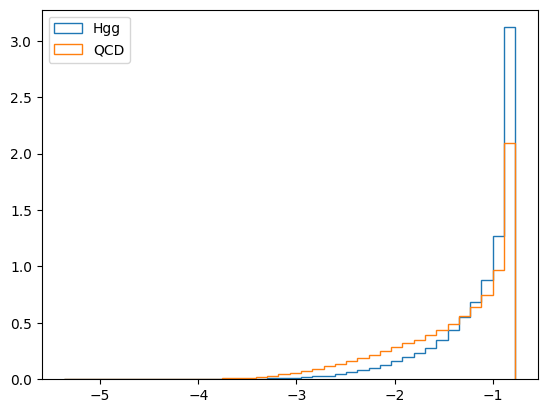

In [48]:
plt.hist(scores['signal']['qt'], bins=40, histtype='step', label='Hgg', density=True)
plt.hist(scores['qcd']['qt'], bins=40, histtype='step', label='QCD', density=True)
plt.legend()
plt.show()

In [49]:
def bkg_output_hist(sample, sample_score1, wp1, sample_score2, wp2, fail, label):
    if fail:
        mask = ~((sample_score1 > wp1) & (sample_score2 > wp2))
        sample_cut_msd = sample.msoftdrop[mask]
    else:
        mask = (sample_score1 > wp1) & (sample_score2 > wp2)
        sample_cut_msd = sample.msoftdrop[mask]
    msd_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{label} MSD").Weight()
    msd_hist.fill(msd=sample_cut_msd)
    return msd_hist

In [50]:
def bkg_output_hist(sample, sample_score1, wp1,fail, label):
    if fail:
        mask = ~((sample_score1 > wp1))
        sample_cut_msd = sample.msoftdrop[mask]
    else:
        mask = (sample_score1 > wp1)
        sample_cut_msd = sample.msoftdrop[mask]
    msd_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"{label} MSD").Weight()
    msd_hist.fill(msd=sample_cut_msd)
    return msd_hist

In [51]:
qt_wp = -.8
dt_wp = 5
obs = 'No Sculpt'

In [52]:
pass_hists = {}
for i in bkg_dict:
    if type(bkg_dict[i]) == dict:
        pass_hists[i] = {}
        for j in bkg_dict[i]:
            msd_hist = bkg_output_hist(bkg_dict[i][j], 
                                       scores[i][j]['qt'], qt_wp, 
                                       #scores[i][j]['dt'], dt_wp,
                                       fail=False,
                                       label='MSD')
            pass_hists[i][j] = msd_hist
    else:
        msd_hist = bkg_output_hist(bkg_dict[i], 
                           scores[i]['qt'], qt_wp, 
                           #scores[i]['dt'], dt_wp,
                           fail=False, 
                           label='MSD')
        pass_hists[i] = msd_hist
    # with open(f'output_hists/pass/{use}_vs_{i}_pass_wp_3.pkl', 'wb') as f:
    #     pickle.dump(msd_hist, f)

In [53]:
fail_hists = {}
for i in bkg_dict:
    if type(bkg_dict[i]) == dict:
        fail_hists[i] = {}
        for j in bkg_dict[i]:
            msd_hist = bkg_output_hist(bkg_dict[i][j], 
                                       scores[i][j]['qt'], qt_wp, 
                                       #scores[i][j]['dt'], dt_wp,
                                       fail=True,
                                       label='MSD')
            fail_hists[i][j] = msd_hist
    else:
        msd_hist = bkg_output_hist(bkg_dict[i], 
                           scores[i]['qt'], qt_wp, 
                           #scores[i]['dt'], dt_wp,
                           fail=True, 
                           label='MSD')
        fail_hists[i] = msd_hist

In [54]:
with open('../jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
del(totals['ww4q'])

In [55]:
with open('../jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)
#del(xsecs['qcd']['qcd_300to470'])

In [56]:
mask = ~((scores['signal']['qt'] > qt_wp) )#& (scores['signal']['dt'] > dt_wp))
sample_cut_msd = signal.msoftdrop[mask]
sig_fail_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"hgg MSD").Weight()
sig_fail_hist.fill(msd=sample_cut_msd);

mask = ((scores['signal']['qt'] > qt_wp) )#& (scores['signal']['dt'] > dt_wp))
sample_cut_msd = signal.msoftdrop[mask]
sig_pass_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"hgg MSD").Weight()
sig_pass_hist.fill(msd=sample_cut_msd);

scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
sig_fail_hist.view(flow=True)[:] *= scaleHgg
sig_pass_hist.view(flow=True)[:] *= scaleHgg

In [57]:
mask = ~((scores['hbb']['qt'] > qt_wp) )#& (scores['hbb']['dt'] > dt_wp))
sample_cut_msd = signal.msoftdrop[mask]
hbb_fail_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"hgg MSD").Weight()
hbb_fail_hist.fill(msd=sample_cut_msd);

mask = ((scores['hbb']['qt'] > qt_wp) )#& (scores['hbb']['dt'] > dt_wp))
sample_cut_msd = signal.msoftdrop[mask]
hbb_pass_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"msd", label=f"hgg MSD").Weight()
hbb_pass_hist.fill(msd=sample_cut_msd);

scaleHbb = ((44.99*(xsecs['hbb']*1000)*0.579)/(totals['hbb']))
hbb_fail_hist.view(flow=True)[:] *= scaleHbb
hbb_pass_hist.view(flow=True)[:] *= scaleHbb

del(pass_hists['hbb'])
del(fail_hists['hbb'])

KeyError: 'hbb'

In [58]:
# del(totals['zqq']['200to400'])
# del(totals['zqq']['400to600'])
# del(totals['zqq']['600to800'])

In [59]:
# del(xsecs['zqq']['zqq_400to600'])
# del(xsecs['zqq']['zqq_600to800'])

In [60]:
Stitched
for i in pass_hists:
    if type(xsecs[i]) == dict:
        scale = ((44.99*(max(xsecs[i].values())*1000))/sum(totals[i][j] for j in totals[i]))
    else:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
    pass_hists[i].view(flow=True)[:] *= scale

for i in pass_hists:
    if type(pass_hists[i]) == dict:
        for j in pass_hists[i]:
            totals_skip = j.find('_')
            scale = ((44.99*(xsecs[i][j]*1000))/totals[i][f'{j[totals_skip+1:]}'])
            pass_hists[i][j].view(flow=True)[:] *= scale
    else:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
        pass_hists[i].view(flow=True)[:] *= scale

In [61]:
# for i in fail_hists:
#     if type(xsecs[i]) == dict:
#         scale = ((44.99*(max(xsecs[i].values())*1000))/sum(totals[i][j] for j in totals[i]))
#     else:
#         scale = ((44.99*(xsecs[i]*1000))/totals[i])
#     fail_hists[i].view(flow=True)[:] *= scale

# for i in fail_hists:
#     if type(fail_hists[i]) == dict:
#         for j in fail_hists[i]:
#             totals_skip = j.find('_')
#             scale = ((44.99*(xsecs[i][j]*1000))/totals[i][f'{j[totals_skip+1:]}'])
#             fail_hists[i][j].view(flow=True)[:] *= scale
#     else:
#         scale = ((44.99*(xsecs[i]*1000))/totals[i])
#         fail_hists[i].view(flow=True)[:] *= scale

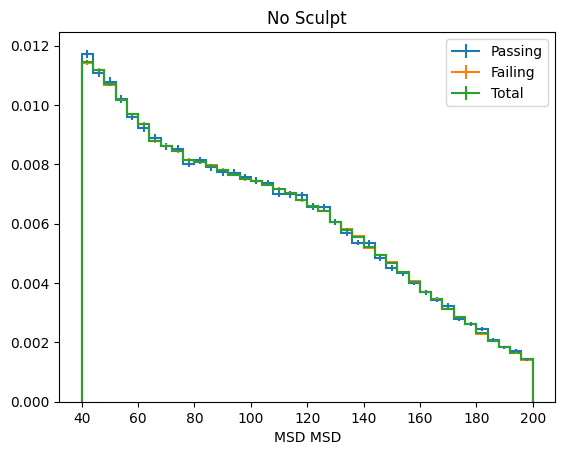

In [62]:
pass_hists['qcd'].plot1d(density=True, label='Passing')
fail_hists['qcd'].plot1d(density=True, label='Failing')
(pass_hists['qcd'] + fail_hists['qcd']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [35]:
sum(pass_hists['qcd'].values()), sum(fail_hists['qcd'].values())

(146778.0, 923220.0)

In [36]:
mask = ~((scores['qcd']['qt'] > qt_wp))
qcd_cut_msd = bkg_dict['qcd'].msoftdrop[mask]
a = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
a.fill(msd=qcd_cut_msd);

In [37]:
mask = ((scores['qcd']['qt'] > qt_wp))
qcd_cut_msd = bkg_dict['qcd'].msoftdrop[mask]
b = hist.Hist.new.Reg(40, 40, 200, name='msd', label='QCD MSD').Weight()
b.fill(msd=qcd_cut_msd);

In [38]:
total_qcd_hist = a + b

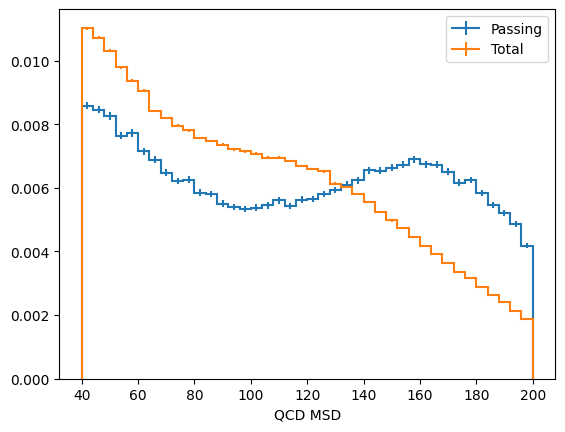

In [39]:
b.plot1d(density=True, label='Passing')
#qcd_fail_hist.plot1d(density=True, label='Failing')
total_qcd_hist.plot1d(density=True, label='Total')
plt.legend()
plt.show()

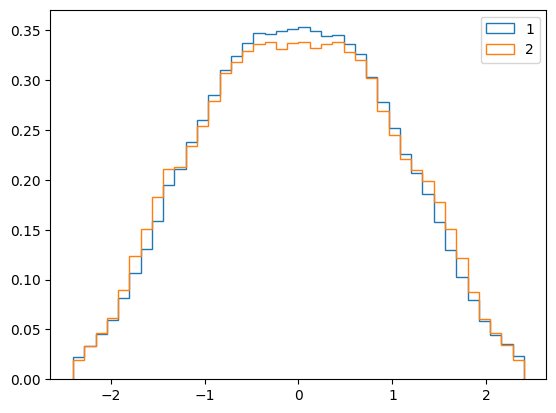

In [76]:
plt.hist(bkg_dict['qcd'].eta, bins=40, histtype='step', label='1', density=True)
plt.hist(bkg_dict2['qcd'].eta, bins=40, histtype='step', label='2', density=True)
plt.legend()
plt.show()

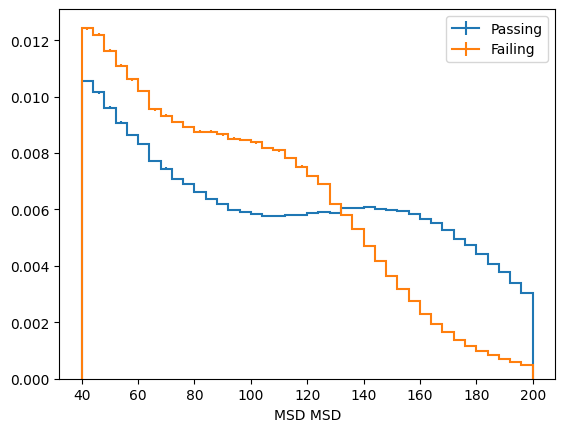

In [127]:
sum([pass_hists['qcd'][i] for i in pass_hists['qcd']]).plot1d(label='Passing', density=True)
sum([fail_hists['qcd'][i] for i in pass_hists['qcd']]).plot1d(label='Failing', density=True)
plt.legend()
plt.show()

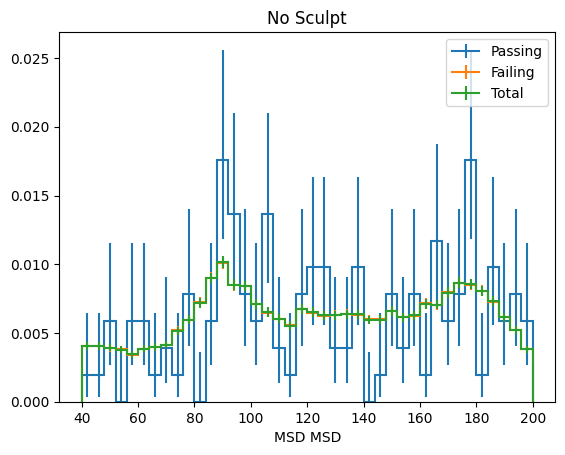

In [26]:
pass_hists['singletop'].plot1d(density=True, label='Passing')
fail_hists['singletop'].plot1d(density=True, label='Failing')
(pass_hists['singletop'] + fail_hists['singletop']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [27]:
sum(pass_hists['singletop'].values()), sum(fail_hists['singletop'].values())

(3.5373930322000025, 414.5658818440019)

In [28]:
# (pass_hists['singletop'] + fail_hists['singletop']).plot1d(density=True)
# plt.hist(bkg_dict['singletop'].msoftdrop, bins=40, histtype='step', density=True)
# plt.show()

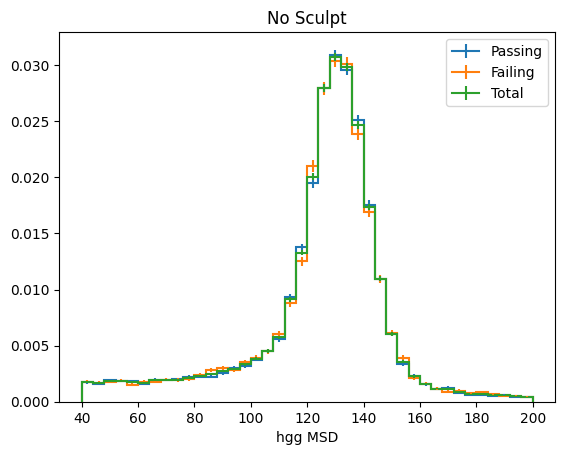

In [29]:
sig_pass_hist.plot1d(density=True, label='Passing')
sig_fail_hist.plot1d(density=True, label='Failing')
(sig_pass_hist + sig_fail_hist).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [30]:
sum(sig_pass_hist.values()), sum(sig_fail_hist.values())

(25.09482125899849, 15.546226573247145)

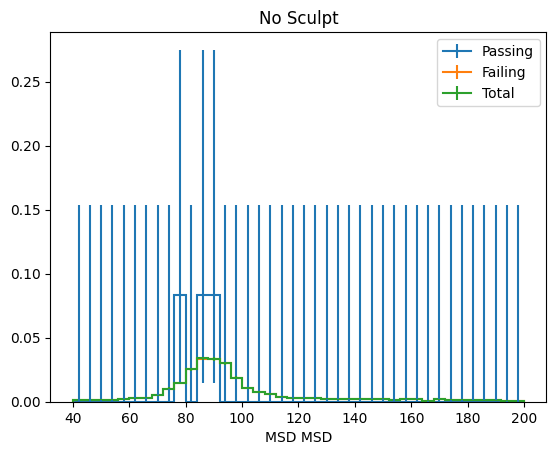

In [31]:
pass_hists['ww'].plot1d(density=True, label='Passing')
fail_hists['ww'].plot1d(density=True, label='Failing')
(pass_hists['ww'] + fail_hists['ww']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [32]:
sum(pass_hists['ww'].values()), sum(fail_hists['ww'].values())

(1.0291377677224736, 1595.8496318149828)

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/mplhep/utils.py:273: RuntimeWarning: divide by zero encountered in scalar divide
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/mplhep/utils.py:245: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/mplhep/utils.py:246: RuntimeWarning: invalid value encountered in multiply
  

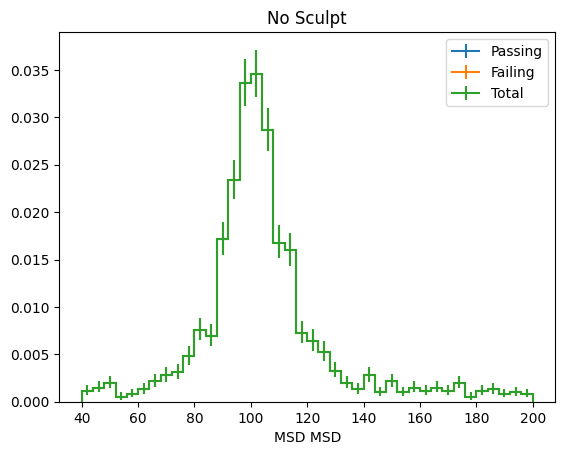

In [33]:
pass_hists['zz'].plot1d(density=True, label='Passing')
fail_hists['zz'].plot1d(density=True, label='Failing')
(pass_hists['zz'] + fail_hists['zz']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [34]:
sum(pass_hists['zz'].values()), sum(fail_hists['zz'].values())

(0.0, 306.39287317073155)

TypeError: index(qcd) cannot be a string for a numerical axis

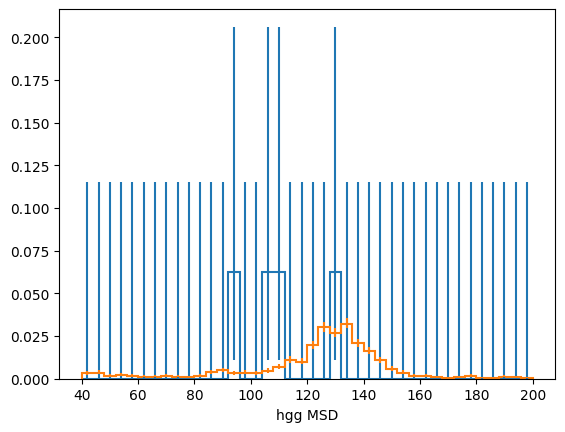

In [35]:
hbb_pass_hist.plot1d(density=True, label='Passing')
hbb_fail_hist.plot1d(density=True, label='Failing')
(hbb_pass_hist['qcd'] + hbb_fail_hist['qcd']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [36]:
sum(hbb_pass_hist.values()), sum(hbb_fail_hist.values())

(0.008104324559489095, 1.9592204622564884)

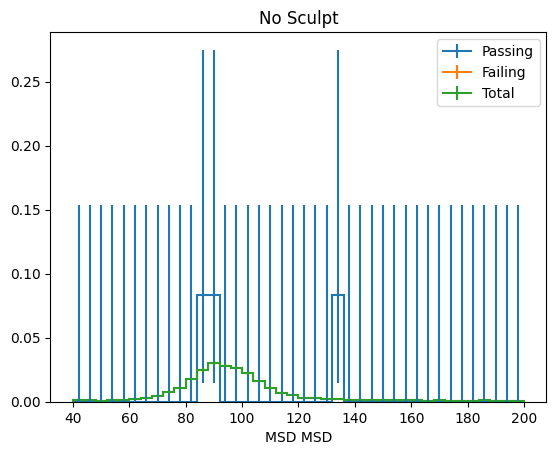

In [37]:
pass_hists['wz'].plot1d(density=True, label='Passing')
fail_hists['wz'].plot1d(density=True, label='Failing')
(pass_hists['wz'] + fail_hists['wz']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [38]:
sum(pass_hists['wz'].values()), sum(fail_hists['wz'].values())

(0.5567689268073642, 802.4896131716805)

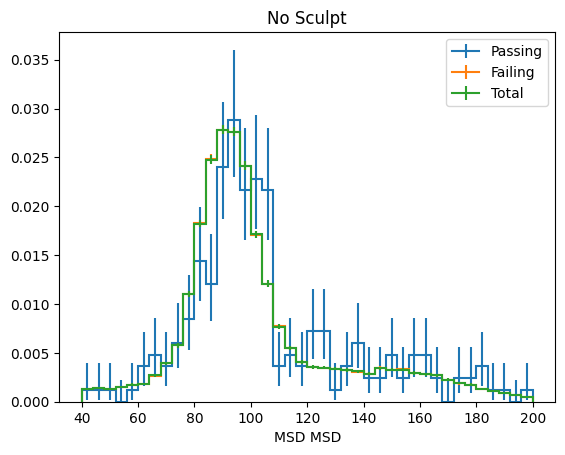

In [39]:
pass_hists['wqq'].plot1d(density=True, label='Passing')
fail_hists['wqq'].plot1d(density=True, label='Failing')
(pass_hists['wqq'] + fail_hists['wqq']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [40]:
sum(pass_hists['wqq'].values()), sum(fail_hists['wqq'].values())

(48.99351119599319, 7280.011781416163)

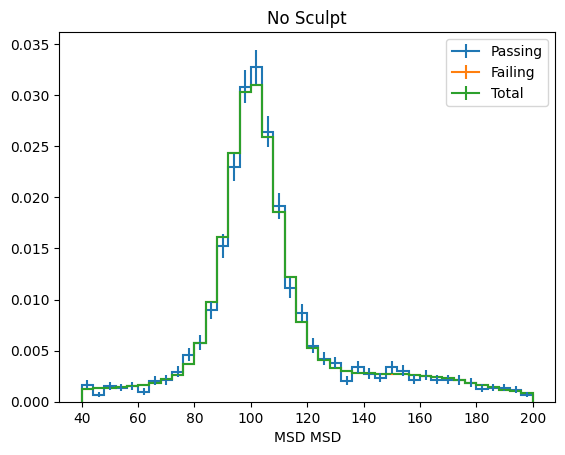

In [41]:
pass_hists['zqq'].plot1d(density=True, label='Passing')
fail_hists['zqq'].plot1d(density=True, label='Failing')
(pass_hists['zqq'] + fail_hists['zqq']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [42]:
sum(pass_hists['zqq'].values()), sum(fail_hists['zqq'].values())

(190.8972489055892, 37323.652889483434)

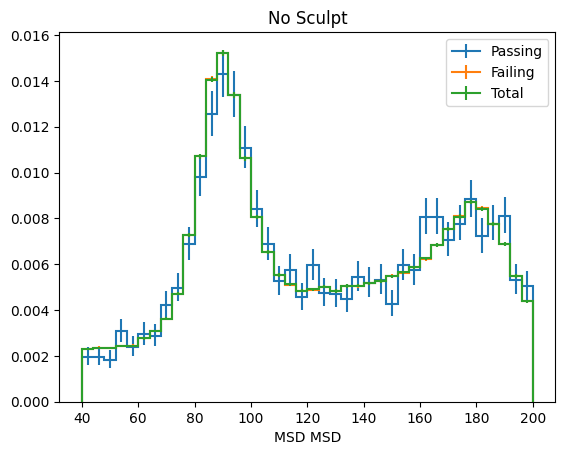

In [43]:
pass_hists['ttboosted'].plot1d(density=True, label='Passing')
fail_hists['ttboosted'].plot1d(density=True, label='Failing')
(pass_hists['ttboosted'] + fail_hists['ttboosted']).plot1d(density=True, label='Total')
plt.legend()
plt.title(f'{obs}')
plt.show()

In [44]:
sum(pass_hists['ttboosted'].values()), sum(fail_hists['ttboosted'].values())

(176.7076682342952, 11767.443757800673)

In [51]:
for i in pass_hists:
    with open(f'../output_hists/pass/hgg/hgg_vs_{i}_pass_qtwp_{qt_wp}_dtwp_{dt_wp}.pkl', 'wb') as f:
        pickle.dump(pass_hists[i], f)
with open(f'../output_hists/pass/hgg/hgg_pass_qtwp_{qt_wp}_dtwp_{dt_wp}.pkl', 'wb') as f:
    pickle.dump(sig_pass_hist, f)
with open(f'../output_hists/pass/hgg/hgg_vs_hbb_pass_qtwp_{qt_wp}_dtwp_{dt_wp}.pkl', 'wb') as f:
    pickle.dump(sig_pass_hist, f)

In [52]:
for i in fail_hists:
    with open(f'../output_hists/fail/hgg/hgg_vs_{i}_fail_qtwp_{qt_wp}_dtwp_{dt_wp}.pkl', 'wb') as f:
        pickle.dump(fail_hists[i], f)
with open(f'../output_hists/fail/hgg/hgg_fail_qtwp_{qt_wp}_dtwp_{dt_wp}.pkl', 'wb') as f:
    pickle.dump(sig_fail_hist, f)
with open(f'../output_hists/fail/hgg/hgg_vs_hbb_fail_qtwp_{qt_wp}_dtwp_{dt_wp}.pkl', 'wb') as f:
    pickle.dump(sig_fail_hist, f)